# Collaborative filtering using graphical models

In the Yelp dataset, consider each restaurant r to have a latent trait t_r, let each user u have a latent preference pu, let the user’s experience at a restaurant be X_u,r = Normal(t_r * p_u, 1), and suppose the user gives a rating of
two or more stars if X_u,r > 0. Use Gibbs sampling to learn the latent variables t_r and p_u.

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io, scipy.stats, scipy.linalg
import pandas as pd
import collections
import seaborn as sns

# Process Yelp Dataset

In [8]:
# Import dataset
reviews_df = pd.read_csv("Users200reviews/reviews.csv")
users_df = pd.read_csv("Users200reviews/users.csv")
restaurants_df = pd.read_csv("Users200reviews/business.csv")


In [ ]:
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)
R = restaurants_df.values.shape[0]
U = users_df.values.shape[0]

In [10]:
reviews = np.array(reviews_df[['user_id', 'business_id', 'stars']].values)

for review in reviews:
    review[0] = users_df.index[users_df.id == review[0]].values[0]
    review[1] = restaurants_df.index[restaurants_df.id == review[1]].values[0]
reviews = reviews.astype(int)

In [12]:
train_reviews = reviews[:10000]
test_reviews = reviews[10000:]

# Visualize data

Distribution of the stars given by the users in the chosen dataset. 

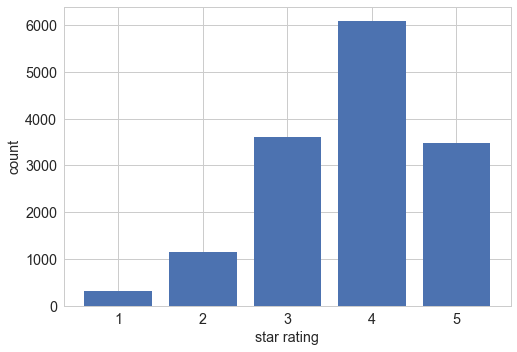

In [14]:
from scipy import stats, integrate

plt.style.use('seaborn')
sns.set_style("whitegrid")
x = [1, 2, 3, 4, 5]

counter = collections.Counter(reviews_df['stars'].values)
plt.bar(x,  [counter[1], counter[2], counter[3], counter[4], counter[5]])

plt.xlabel('star rating', fontsize='x-large')
plt.ylabel('count', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')

plt.savefig("stars_count.pdf")
plt.show()

# Modeling a single trait and a binary outcome

In [ ]:
def rejection_sampling(mu, std, rating):
    if rating>3:
        sign = 1
    else: 
        sign = -1
    while True:
        x = np.random.normal(loc=mu, scale=std)
        if np.sign(x)==sign:
            return x

In [ ]:
def Gibbs_sampling_single_trait_binary_rating(reviews):

    pv_t = np.ones(R)   # prior variance for restaurant traits
    t = np.zeros(R)     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = np.ones(U)   # prior variance for user preferences
    p = np.zeros(U)     # user preferences, initialized to be the prior mean mu_0 = 0

    x = np.zeros(reviews.shape[0]) 
    
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(1500):
        
        if num%250==0:
            print (num)
        
        # Sample user experience (x) given 
        # user preferences (p), restaurant traits (t) and rating (y)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling(s, 1, reviews[r][2])
            
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * 
                                   (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * 
                        ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * 
                                   (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * 
                        ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))

        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return restaurant_traits_samples, user_preferences_samples

In [ ]:
single_trait_restaurant_traits_samples, single_trait_user_preferences_samples = 
    Gibbs_sampling_single_trait_binary_rating(train_reviews)

# Burn-in time for Gibbs sampler

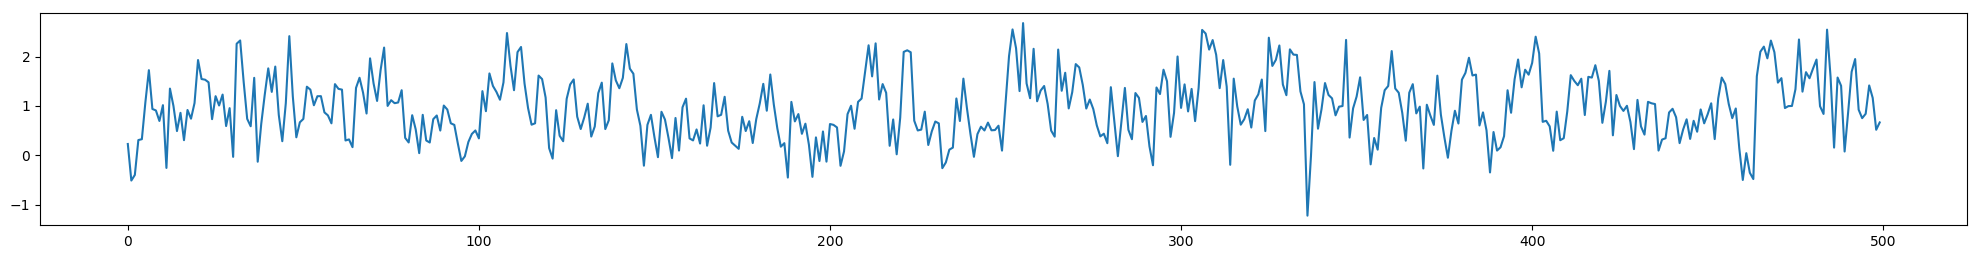

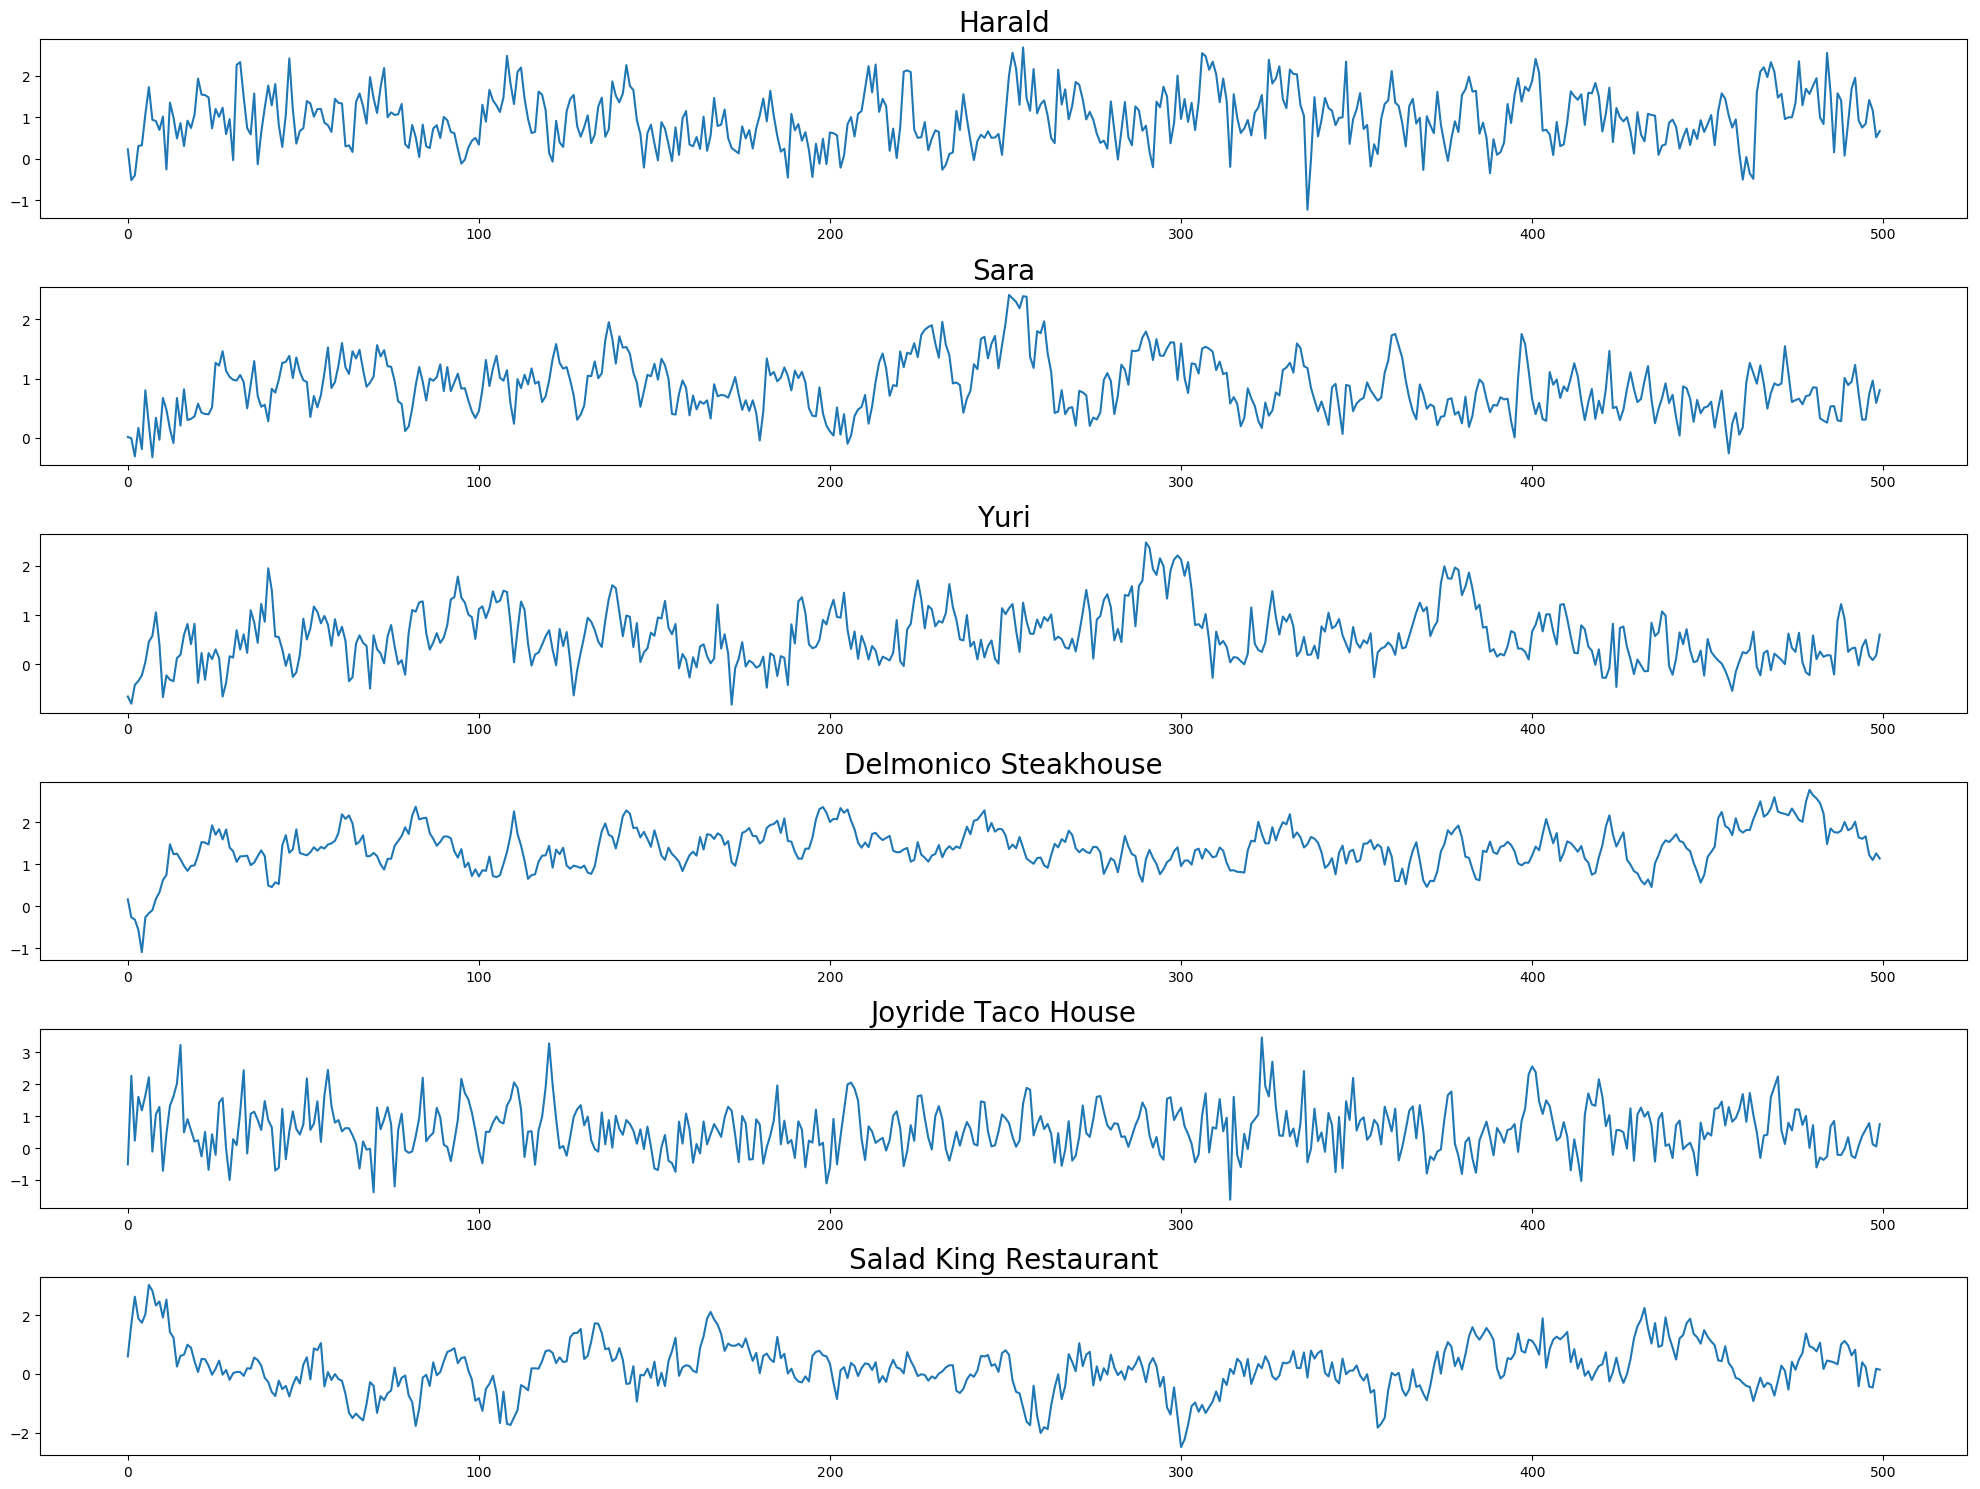

In [395]:
users = [0, 1, 2]
restaurants = [0, 1, 2]

with matplotlib.rc_context({'figure.figsize': [20,15], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+1)
        fig.tight_layout()
        fig.tight_layout()
        ax.plot(single_trait_user_preferences_samples[:500, users[i]])
        ax.set_title(users_df.get_value(users[i], 'name'))
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+4)
        fig.tight_layout()
        ax.plot(single_trait_restaurant_traits_samples[:500, restaurants[i]])
        ax.set_title(restaurants_df.get_value(restaurants[i], 'name'))
plt.show()

The burning time represents the time required to get from the initial random location in the Gibbs sampler to a location that has a high probability under the posterior. By looking at the user preferences and restaurant traits for each iteration we can notice that the burning time is about 40 iterations. 

# Mixing time for Gibbs sampler

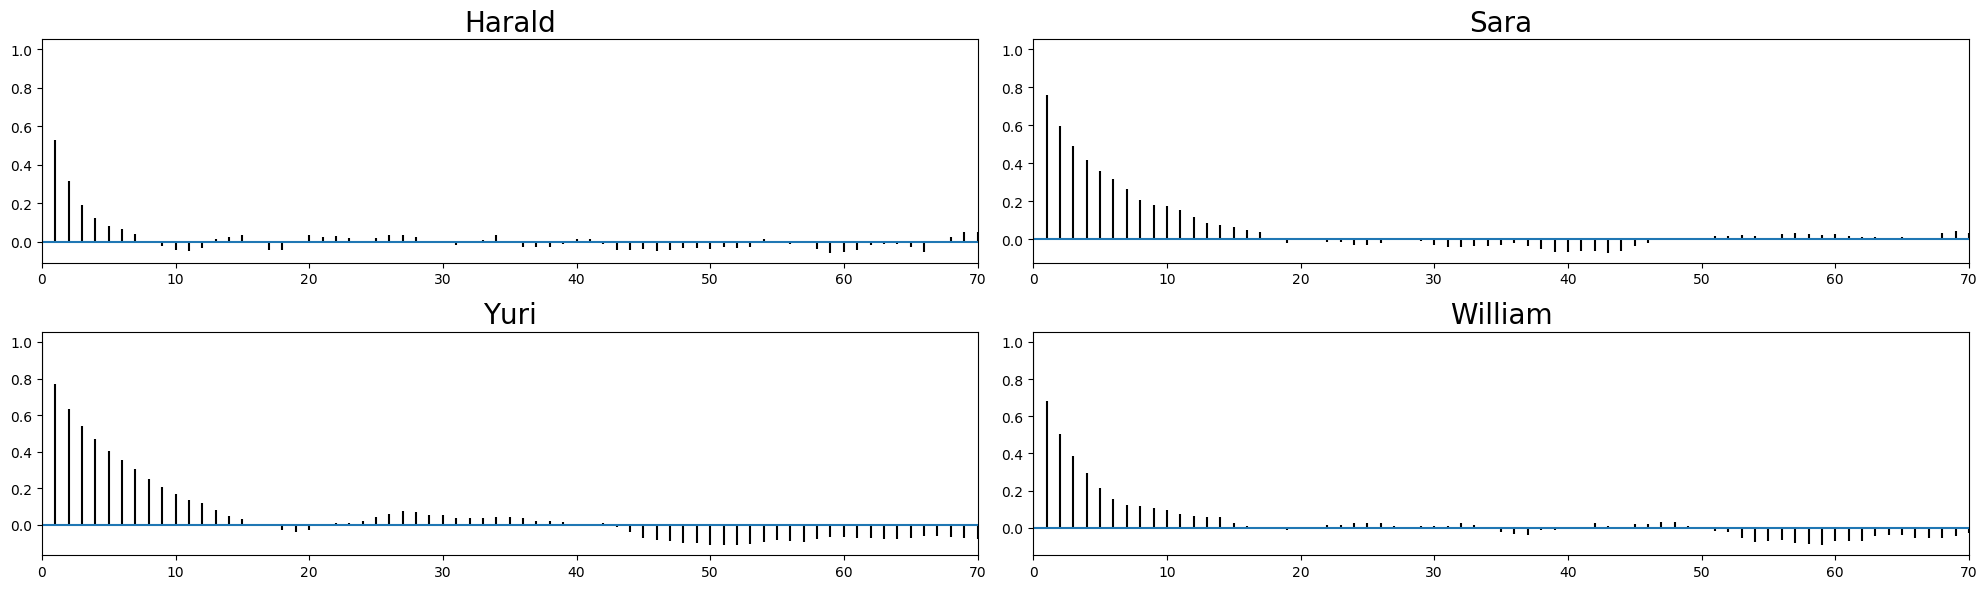

In [393]:
users = [0, 1, 2, 3]

with matplotlib.rc_context({'figure.figsize': [20,6], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)  # 2 rows of panels, 3 columns
        fig.tight_layout()
        ax.acorr(single_trait_user_preferences_samples[:, users[i]] - 
                 np.mean(single_trait_user_preferences_samples[:, users[i]]), maxlags=70)
        ax.set_title(users_df.get_value(users[i], 'name'))
        ax.set_xlim(0,70)
plt.show()

Conversely, the mixing time is given by the time required for the samples to become uncorrelated. By looking at the autocorrelation plots, we can say that the mixing time is about 15-20 iterations.

# Ranked user preferences 

In [ ]:
mean_preferences = np.mean(user_preferences_samples[50:], axis=0)[:100]
std_preferences = np.std(user_preferences_samples[50:], axis=0)[:100]
rank_order = np.argsort(mean_preferences)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(100)
    plt.bar(x, mean_preferences[rank_order], align='center', width=.8, 
            yerr=std_preferences[rank_order], color='green')
    plt.xticks(x, users_df.iloc[rank_order]['name'].values, rotation=-90, ha='right')
    plt.ylabel('user preferences')
plt.show()

# Ranked restaurant traits

In [ ]:
mean_traits = np.mean(restaurant_traits_samples[50:], axis=0)[:100]
std_traits = np.std(restaurant_traits_samples[50:], axis=0)[:100]
rank_order = np.argsort(mean_traits)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(100)
    plt.bar(x, mean_traits[rank_order], align='center', width=.8, 
            yerr=std_traits[rank_order], color='red')
    plt.xticks(x, restaurants_df.iloc[rank_order]['name'].values, rotation=-90, ha='right')
    plt.ylabel('restaurant traits')
plt.show()

# Modeling multiple traits and a binary outcome

In [ ]:
def compute_precision_for_restaurants(K, id, traits, reviews):
    precision = np.zeros(shape=(K,K))
    restaurant_reviews = np.where((reviews[:, 1] == id))[0]

    for i in range(restaurant_reviews.shape[0]):
        precision = precision + np.outer(traits[reviews[restaurant_reviews[i], 0]], 
                                         traits[reviews[restaurant_reviews[i], 0]])
    
    return precision

def compute_mean_of_posterior_for_restaurants(K, id, traits, reviews, user_experience):
    mean = np.zeros(K)
    restaurant_reviews = np.where((reviews[:, 1] == id))[0]
    
    for i in range(restaurant_reviews.shape[0]):
        mean = mean + user_experience[restaurant_reviews[i]] * 
                        traits[reviews[restaurant_reviews[i], 0]]

    return mean

def compute_precision_for_users(K, id, traits, reviews):
    precision = np.zeros(shape=(K,K))
    user_reviews = np.where((reviews[:, 0] == id))[0]

    for i in range(user_reviews.shape[0]):
        precision = precision + np.outer(traits[reviews[user_reviews[i], 1]], 
                                         traits[reviews[user_reviews[i], 1]])
    return precision

def compute_mean_of_posterior_for_users(K, id, traits, reviews, user_experience):
    mean = np.zeros(K)
    user_reviews = np.where((reviews[:, 0] == id))[0]
    
    for i in range(user_reviews.shape[0]):
        mean = mean + user_experience[user_reviews[i]] * traits[reviews[user_reviews[i], 1]]

    return mean

In [ ]:
def Gibbs_sampling_multiple_traits_binary_rating(reviews, K):

    pv_t = np.ones(shape=(R, K))   # prior variance for restaurant traits
    t = np.zeros((R, K))     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = np.ones((U, K))   # prior variance for user preferences
    p = np.zeros((U, K))     # user preferences, initialized to be the prior mean mu_0 = 0

    x = np.zeros(reviews.shape[0]) 
    
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(1500):
        
        if (num%100==0):
            print (num)
        
        # Sample user experience (x) 
        # given user preferences (p), restaurant traits (t) and rating (y)
        for r in range(reviews.shape[0]):
            s = np.dot(p[reviews[r][0]], t[reviews[r][1]])
            x[r] = rejection_sampling(s, 1, reviews[r][2])
            
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(shape=(R, K)) 
        for i in range(R):
            sigma_inv = np.diag(1./pv_t[i]) + 
                            compute_precision_for_restaurants(K, i, p, reviews)  
            sigma = np.linalg.inv(sigma_inv)
            mu_tilde = compute_mean_of_posterior_for_restaurants(K, i, p, reviews, x) 
            mu = np.dot(sigma, mu_tilde)
            t[i] = np.random.multivariate_normal(mean=mu, cov=sigma)
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(shape=(U, K))  
        for i in range(U):
            sigma_inv = np.diag(1./pv_p[i]) + 
                            compute_precision_for_users(K, i, t, reviews) 
            sigma = np.linalg.inv(sigma_inv)
            mu_tilde = compute_mean_of_posterior_for_users(K, i, t, reviews, x) 
            mu = np.dot(sigma, mu_tilde)
            p[i] = np.random.multivariate_normal(mean=mu, cov=sigma)

        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return restaurant_traits_samples, user_preferences_samples

In [ ]:
restaurants_vary_num_traits = []
users_vary_num_traits = []

for i in range(1, 11):
    multiple_traits_restaurant_traits_samples, multiple_traits_user_preferences_samples = 
            Gibbs_sampling_multiple_traits_binary_rating(train_reviews, i)
    restaurants_vary_num_traits.append(multiple_traits_restaurant_traits_samples)
    users_vary_num_traits.append(multiple_traits_user_preferences_samples)
    

# Compute variance of traits

In [ ]:
for i in range(10):
    std_user_traits = np.std(users_vary_num_traits[i][50:], axis=0)
    #print(np.where(std_user_traits < 0.5)[0].shape)
    std_restaurant_traits = np.std(restaurants_vary_num_traits[i][50:], axis=0)
    count = 0 
    for std in std_user_traits:
        cond = True
        #print (std)
        for j in range(i+1):
            if std[j] > 0.8:
                cond = False
        if cond is True:
            count = count + 1

    print (count)

In [ ]:
def compute_like_probability(user, restaurant, 
                             user_preferences_samples, restaurant_traits_samples):
    num_samples = 5000
    prob = 0
    for i in range(num_samples):
        idx = np.random.randint(1500, size=1)[0]
        restaurant_trait = restaurant_traits_samples[idx][restaurant]
        user_preference = user_preferences_samples[idx][user]
        experience = np.dot(user_preference,restaurant_trait)
        if experience > 0:
            prob +=1
    prob = float(prob)/float(num_samples)
    return prob

In [ ]:
import math

def normalized_discounted_cumulative_gain(test_reviews, restaurant_traits_samples, user_preferences_samples):
    num_test_reviews = test_reviews.shape[0]
    ndcg = 0.0
    for user in range(U):
        like_probability = []
        user_reviews = reviews[np.where((test_reviews[:, 0] == user))[0]]
        if(user_reviews.shape[0] == 0):
            continue
        restaurants = user_reviews[:, 1]
        for restaurant in restaurants:
            like_probability.append(compute_like_probability(
                user, restaurant, user_preferences_samples, restaurant_traits_samples))
        like_probability = np.array(like_probability)
        rank_order = np.flip(np.argsort(like_probability), axis=0)
        
        like_probability =  like_probability[rank_order]
        user_reviews = user_reviews[rank_order]
        
        score = 0.0
        normalization_score = 0.0
        
        top_stars = np.flip(np.sort(user_reviews[:, 2]), axis=0)[:5]
        
        discount_factor = [1.0, 0.63, 0.5, .43, .39]
        for i in range(min(top_stars.shape[0], 5)):
            score = score + discount_factor[i] * float(user_reviews[i][2])                                            
            normalization_score = normalization_score + 
                                    discount_factor[i] * float(top_stars[i])
            
        ndcg = ndcg + (score/normalization_score)
    
    return ndcg/U
    
normalized_discounted_cumulative_gain(test_reviews, 
                                      restaurants_vary_num_traits[4], 
                                      users_vary_num_traits[4])

# Evaluate accuracy of predicting correct rating on test reviews 

In [ ]:
def compute_accuracy(test_reviews, restaurant_traits_samples, user_preferences_samples):
    num_test_reviews = test_reviews.shape[0]
    num = 0
    num_samples=100
    for test_review in test_reviews:
        user = test_review[0]
        restaurant = test_review[1]

        prob = compute_like_probability(user, restaurant, 
                                        user_preferences_samples, restaurant_traits_samples)
        if prob>=0.5:
            experience = 1
        else:
            experience = -1
        if test_review[2] > 3:
            sign = 1
        else:
            sign = -1

        if experience == sign:
            num = num + 1

    return (float(num)/float(num_test_reviews))

# Modeling single trait and star ratings

In [ ]:
def rejection_sampling_user_experience(mu, std, rating, threshold):
    while True:
        x = np.random.normal(loc=mu, scale=std)
        cond = True        
        for i in range(1, rating+1):
            if (np.sign(x-threshold[i]) == -1):
                cond = False
        for i in range(rating+1, 6):
            if (np.sign(x-threshold[i]) == 1):
                cond = False
        if cond:
            return x

def rejection_sampling_star_threshold(star, x, reviews, mu, std):
    while True:
        threshold = np.random.normal(loc=mu, scale=std)
        cond = True
        for i in range (star, 6):
            if (-1 in ((np.sign(x-threshold)) * (reviews[:, 2]==i).astype(int))):
                cond = False
        for i in range (1, star):
            if (1 in ((np.sign(x-threshold)) * (reviews[:, 2]==i).astype(int))):
                cond = False
        if cond:
            return threshold

In [ ]:
def Gibbs_sampling_single_trait_star_rating(reviews):

    pv_t = 1 * np.ones(R)   # prior variance for restaurant traits
    t =  np.zeros(R)     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = 1 * np.ones(U)   # prior variance for user preferences
    p = np.zeros(U)     # user preferences, initialized to be the prior mean mu_0 = 0
    
    pv_h = 10 * np.ones(6) 
    pm_h = [0, -2, -1, 0, 1, 2]
    
    h = [0, -2, -1, 0, 1, 2]
    
    x = np.zeros(reviews.shape[0]) 
    
    star_threshold_samples = []
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(200):
        # Sample user experience (x) 
        # given user preferences (p), restaurant traits (t), star thresholds (h) and rating (y)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling_user_experience(s, 1, reviews[r][2], h)  
            
        # Sample star thresholds h2, h4 and h5 
        # given user preferences (p), restaurant traits (t), user_experiences (x) and rating (y)
        h = np.zeros(6) 
        for i in range (1, 6):
            h[i] = rejection_sampling_star_threshold(i, x, reviews, pm_h[i], pv_h[i])
        
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * 
                                   (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
        
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * 
                                   (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
            

        star_threshold_samples.append(h)
        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)
           

    star_threshold_samples = np.array(star_threshold_samples)
    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return star_threshold_samples, restaurant_traits_samples, user_preferences_samples